## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.


Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course \


Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [94]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [95]:
# (re-)load layers
%run modules.ipynb

<>:2: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_6863/2367876760.py:2: SyntaxWarning: invalid escape sequence '\g'
  """


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

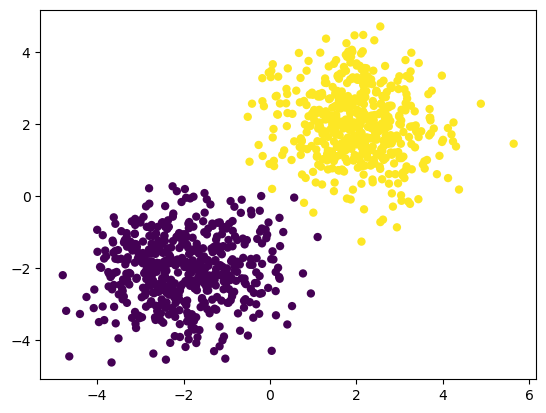

In [96]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [97]:

net = Sequential()
net.add(Linear(2, 16))
net.add(ReLU())
net.add(Linear(16, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)



Linear 2 -> 16
ReLU
Linear 16 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [98]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 256

In [99]:

# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

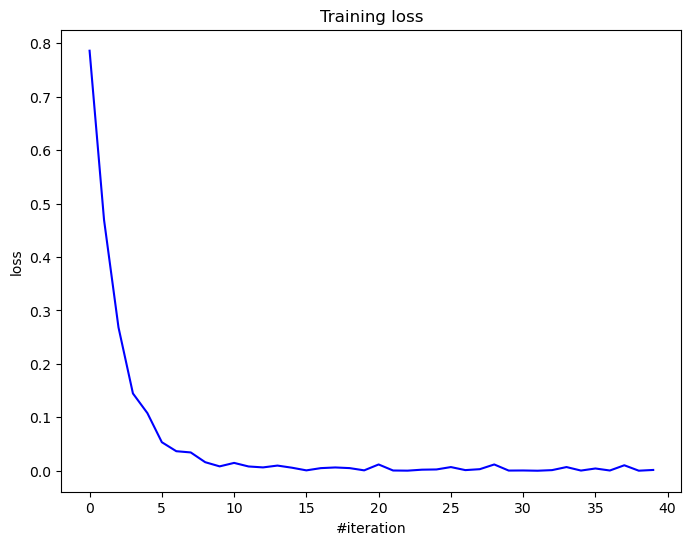

Current loss: 0.001501


In [100]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [101]:
output = net.forward(X)
predictions = np.argmax(output, axis=1)
true_labels = np.argmax(Y, axis=1)

# Вычисление точности
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 99.90%


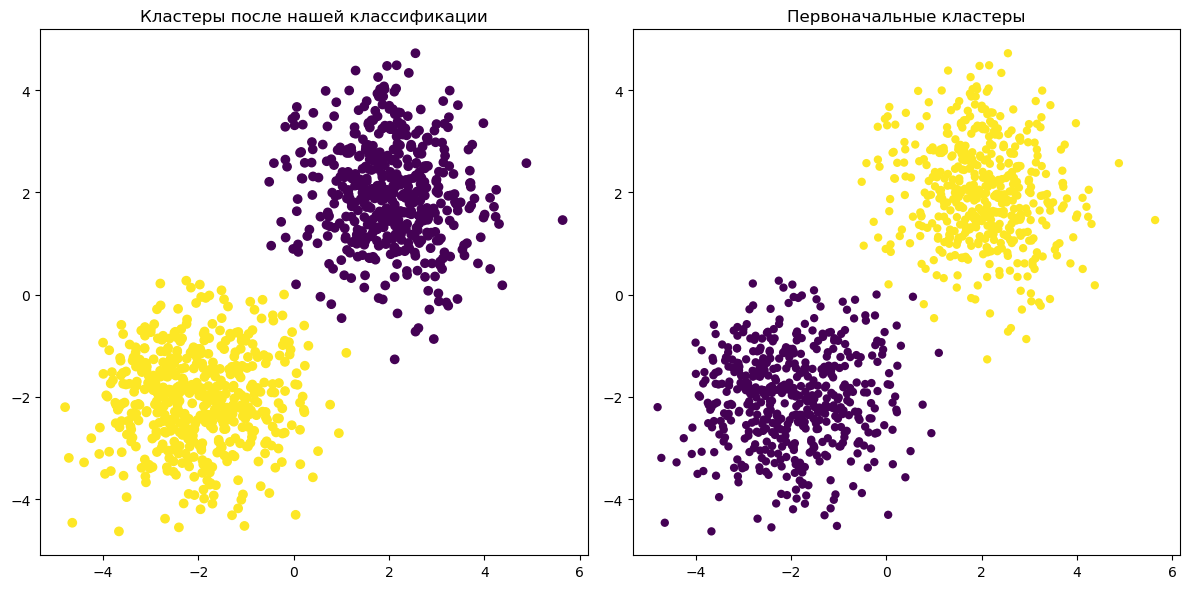

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Первый scatterplot
ax1.scatter(X[:, 0], X[:, 1], c=predictions)
ax1.set_title("Кластеры после нашей классификации")


# Второй scatterplot
ax2.scatter(X[:, 0], X[:, 1], c = Y[:,0], edgecolors='none')
ax2.set_title("Первоначальные кластеры")


# Отображаем графики
plt.tight_layout()
plt.show()

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [103]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [104]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):        
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())        
    
    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())        
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img            
    
    return images, labels
    

In [105]:
train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

val_size = 10000 

X_train, X_val = train_images[:-val_size], train_images[-val_size:]
y_train, y_val = train_labels[:-val_size], train_labels[-val_size:]


X_test, y_test = test_images, test_labels


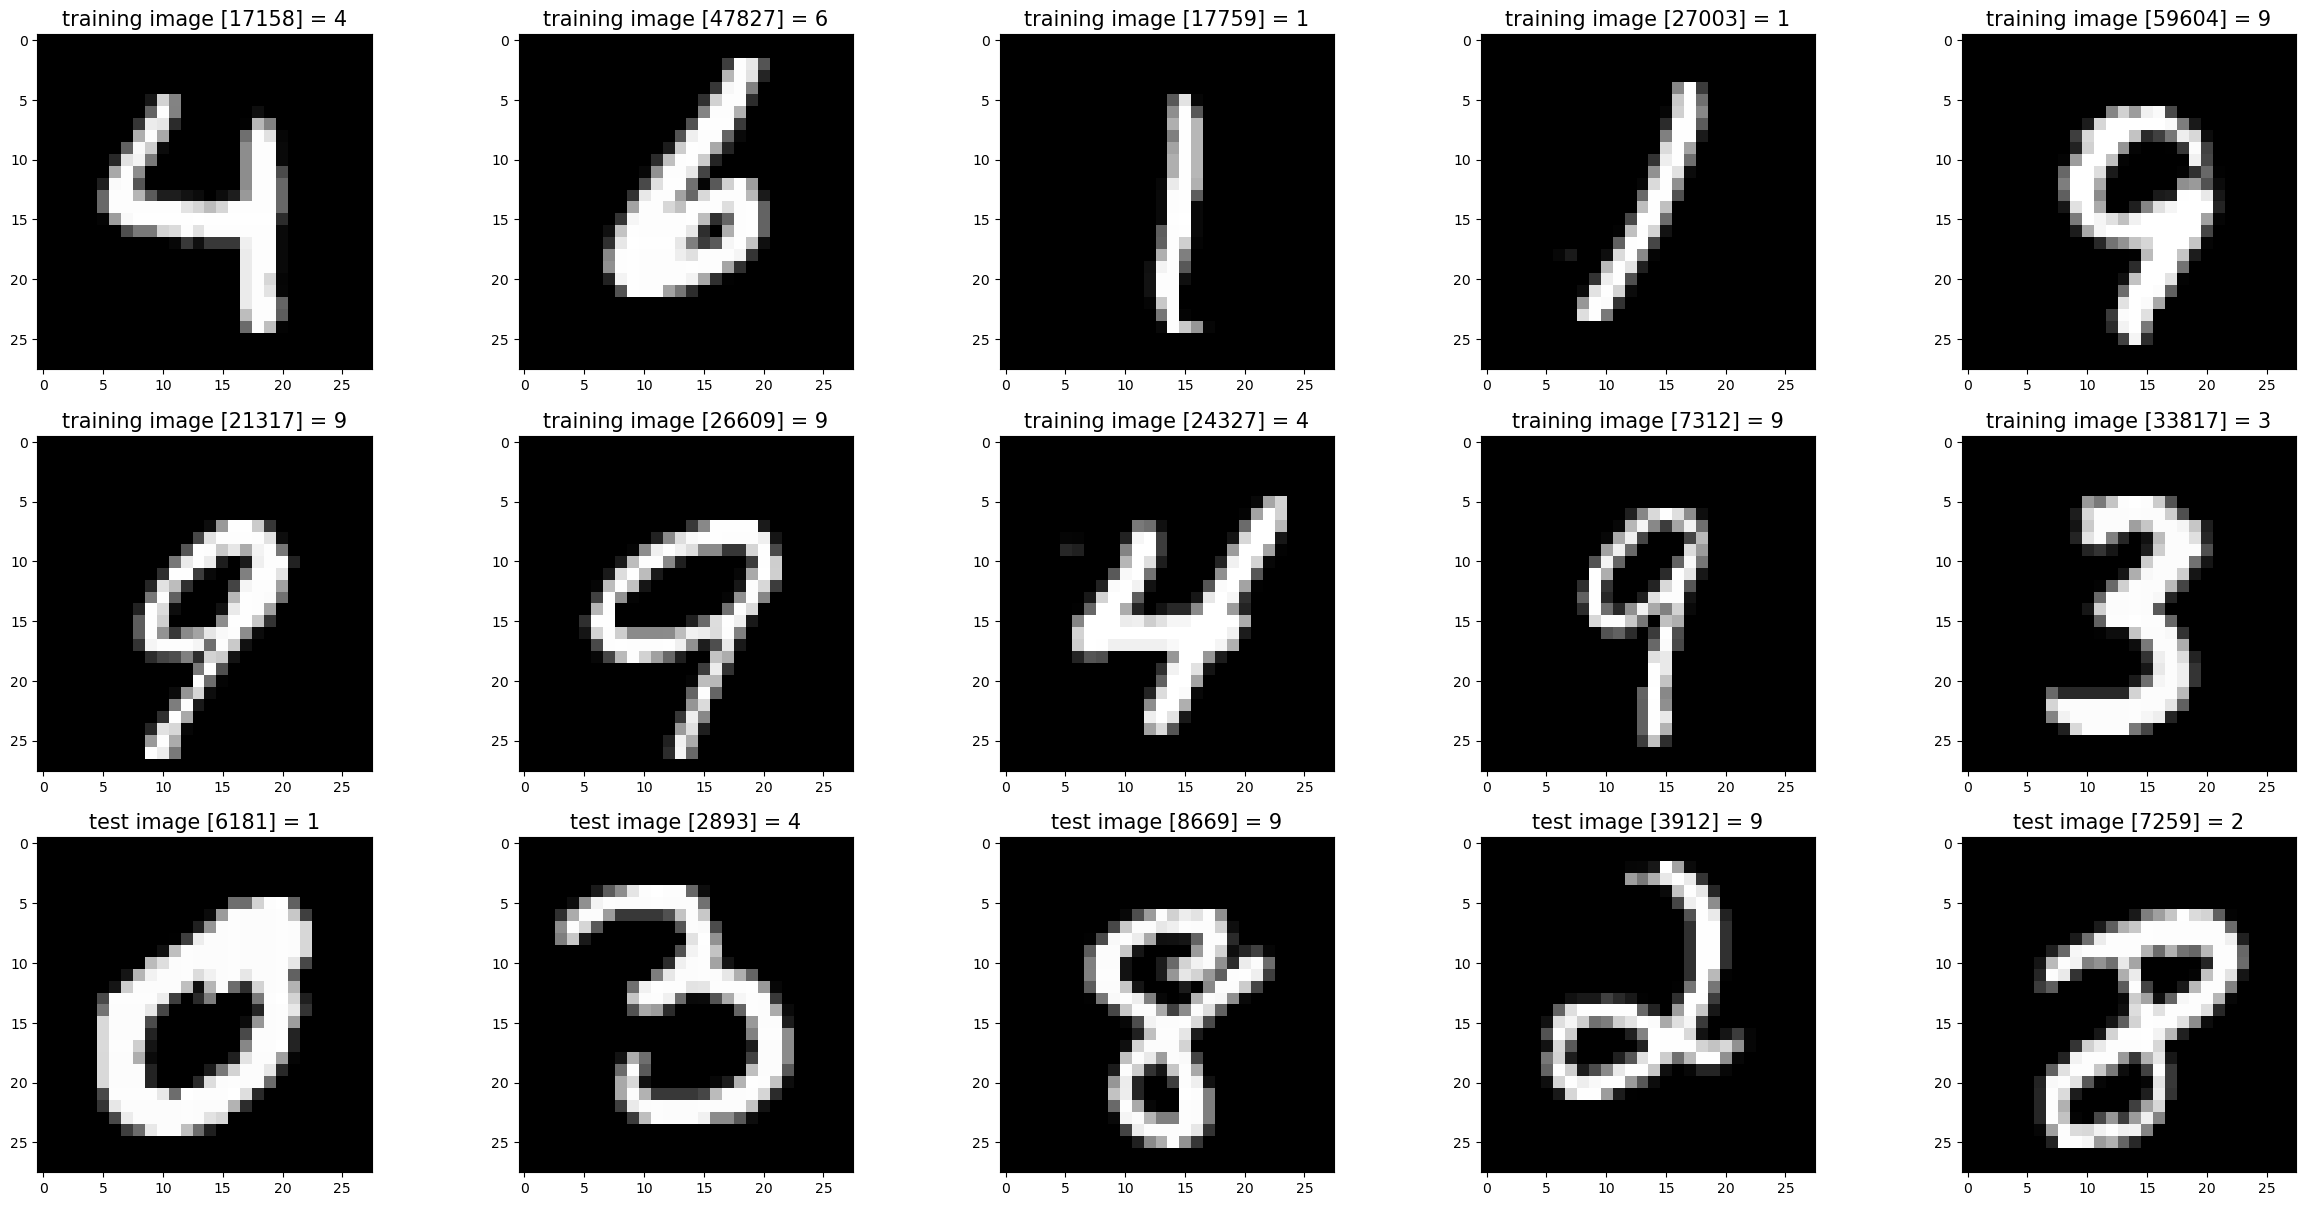

In [106]:
#
# Verify Reading Dataset via MnistDataloader class
#
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_images[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_images[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(train_labels[r]))    

show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

In [107]:
# Your code goes here. ################################################

X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


def one_hot(labels, num_classes=10):
    ohe = np.zeros((labels.size, num_classes))
    ohe[np.arange(labels.size), labels] = 1
    return ohe



y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test = one_hot(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [108]:
# Модель с активацией ReLU
model_relu = Sequential()
model_relu.add(Flatten())
model_relu.add(Linear(784, 100))
model_relu.add(ReLU())
model_relu.add(Linear(100, 10))
model_relu.add(LogSoftMax())
print("Структура модели:  \n", model_relu)

Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [109]:
# Модель с активацией ReLU для бача другого размера
model_relu3 = Sequential()
model_relu3.add(Flatten())
model_relu3.add(Linear(784, 100))
model_relu3.add(ReLU())
model_relu3.add(Linear(100, 10))
model_relu3.add(LogSoftMax())
print("Структура модели:  \n", model_relu3)

Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [110]:
# Модель с активацией ReLU и BatchNorm
model_relu_bn = Sequential()
model_relu_bn.add(Flatten())
model_relu_bn.add(Linear(784, 100))
model_relu_bn.add(BatchNormalization())
model_relu_bn.add(ChannelwiseScaling(100))
model_relu_bn.add(ReLU())
model_relu_bn.add(Linear(100, 10))
model_relu_bn.add(LogSoftMax())
print("Структура модели:  \n", model_relu_bn)


Структура модели:  
 Flatten
Linear 784 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [111]:
# Модель с активацией ReLU и BatchNorm для другого размера бача
model_relu_bn1 = Sequential()
model_relu_bn1.add(Flatten())
model_relu_bn1.add(Linear(784, 100))
model_relu_bn1.add(BatchNormalization())
model_relu_bn1.add(ChannelwiseScaling(100))
model_relu_bn1.add(ReLU())
model_relu_bn1.add(Linear(100, 10))
model_relu_bn1.add(LogSoftMax())
print("Структура модели:  \n", model_relu_bn1)

Структура модели:  
 Flatten
Linear 784 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [112]:
# Модель с активацией ELU с альфа 1
model_elu = Sequential()
model_elu.add(Flatten())
model_elu.add(Linear(784, 100))
model_elu.add(ELU(alpha=1))
model_elu.add(Linear(100, 10))
model_elu.add(LogSoftMax())
print("Структура модели:  \n", model_elu)


Структура модели:  
 Flatten
Linear 784 -> 100
ELU
Linear 100 -> 10
LogSoftMax



In [113]:
# Модель с активацией ELU с альфа 0.5
model_elu1 = Sequential()
model_elu1.add(Flatten())
model_elu1.add(Linear(784, 100))
model_elu1.add(ELU(alpha=0.5))
model_elu1.add(Linear(100, 10))
model_elu1.add(LogSoftMax())
print("Структура модели:  \n", model_elu1)

Структура модели:  
 Flatten
Linear 784 -> 100
ELU
Linear 100 -> 10
LogSoftMax



In [114]:
# Модель с активацией LeakyReLU
model_leaky = Sequential()
model_leaky.add(Flatten())
model_leaky.add(Linear(784, 100))
model_leaky.add(LeakyReLU())
model_leaky.add(Linear(100, 10))
model_leaky.add(LogSoftMax())
print("Структура модели:  \n", model_leaky)

Структура модели:  
 Flatten
Linear 784 -> 100
LeakyReLU
Linear 100 -> 10
LogSoftMax



In [115]:
# Модель с активацией SoftPlus
model_softplus = Sequential()
model_softplus.add(Flatten())
model_softplus.add(Linear(784, 100))
model_softplus.add(SoftPlus())
model_softplus.add(Linear(100, 10))
model_softplus.add(LogSoftMax())
print("Структура модели: \n",model_softplus)

Структура модели: 
 Flatten
Linear 784 -> 100
SoftPlus
Linear 100 -> 10
LogSoftMax



In [116]:
# Модель с активацией ReLU Dropout BatchNorm
model_relu_final = Sequential()
model_relu_final.add(Flatten())
model_relu_final.add(Linear(784, 392))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(392))
model_relu_final.add(ReLU())  
model_relu_final.add(Linear(392, 392))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(392))
model_relu_final.add(Dropout(0.5))
model_relu_final.add(Linear(392, 100))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(100))
model_relu_final.add(ReLU())
model_relu_final.add(Linear(100, 10))
model_relu_final.add(LogSoftMax())
print("Структура модели:  \n", model_relu_final)

Структура модели:  
 Flatten
Linear 784 -> 392
BatchNormalization
ChannelwiseScaling
ReLU
Linear 392 -> 392
BatchNormalization
ChannelwiseScaling
Dropout
Linear 392 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [117]:
# Еще модель с активацией ReLU Dropout BatchNorm с другими линейными слоями

model_relu_final1 = Sequential()
model_relu_final1.add(Flatten())
model_relu_final1.add(Linear(784, 256))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(256))
model_relu_final1.add(ReLU())  
model_relu_final1.add(Dropout(0.5))
model_relu_final1.add(Linear(256, 128))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(128))
model_relu_final1.add(ReLU())  
model_relu_final1.add(Dropout(0.5))
model_relu_final1.add(Linear(128, 64))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(64))
model_relu_final1.add(ReLU())
model_relu_final1.add(Linear(64, 10))
model_relu_final1.add(LogSoftMax())
print("Структура модели:  \n", model_relu_final1)

Структура модели:  
 Flatten
Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 64
BatchNormalization
ChannelwiseScaling
ReLU
Linear 64 -> 10
LogSoftMax



In [118]:
# Еще модель с активацией ReLU Dropout BatchNorm с большим количеством слоев
model_relu_final2 = Sequential()

model_relu_final2.add(Flatten())

model_relu_final2.add(Linear(784, 512))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(512))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.2))  # Меньший dropout в начале

model_relu_final2.add(Linear(512, 512))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(512))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.3))

model_relu_final2.add(Linear(512, 256))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(256))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.4))

model_relu_final2.add(Linear(256, 128))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(128))
model_relu_final2.add(ReLU())
model_relu_final2.add(Dropout(0.5))


model_relu_final2.add(Linear(128, 10))
model_relu_final2.add(LogSoftMax())

print("Структура модели:  \n", model_relu_final2)

Структура модели:  
 Flatten
Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 512 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 10
LogSoftMax



In [142]:
# Модель с активацией ReLU для другого оптимизатора
model_relu2 = Sequential()
model_relu2.add(Flatten())
model_relu2.add(Linear(784, 100))
model_relu2.add(ReLU())  
model_relu2.add(Linear(100, 10))
model_relu2.add(LogSoftMax())
print("Структура модели:  \n", model_relu2)


Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [120]:
def train_mnist(train_x, train_y, val_x, val_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, beta1=0.9, beta2=0.999, EPS=1e-8, lr_decay=1):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        val_x: валидационные данные (изображения).
        val_y: валидационные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        beta1: beta1 для Adam оптимизатора.
        beta2: beta2 для Adam оптимизатора.
        EPS: малое значение для предотвращения деления на ноль.

    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на валидационной выборке.
        test_accuracies: список значений точности на валидации выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'beta1': beta1,
        'beta2': beta2,
        'epsilon': EPS
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    val_losses = []
    val_accuracies = []


    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()

        # Изменяем скорость обучения каждые 6 эпох
        if lr_decay != 1:
            if (epoch + 1) % 6 == 0:
                optimizer_config['learning_rate'] *= lr_decay
                print(f"Learning rate decreased to {optimizer_config['learning_rate']}")
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            adam_optimizer(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
        model.evaluate()
        val_predictions = model.forward(val_x)
        val_loss = criterion.forward(val_predictions, val_y)
        accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(val_y, axis=1))
    
        # Сохраняем метрики
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Val loss: {val_loss:.4f}, Val acc : {accuracy:.4f}")

    # model.evaluate()
    
    test_predictions = model.forward(test_x)
    test_loss = criterion.forward(val_predictions, val_y)
    test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))
    print("\nПроверяем модель на тестовой выборке : ")
    print(f"Test loss: {test_loss:.4f}, Test acc : {test_accuracy:.4f}")

    return model, val_losses, val_accuracies, test_loss, test_accuracy

In [121]:
def train_mnist_sgd(train_x, train_y, val_x, val_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, momentum=0.9):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        val_x: валидационные данные (изображения).
        val_y: валидационные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        momentum: параметр для SDG оптимизатора


    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на тестовой выборке.
        test_accuracies: список значений точности на тестовой выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'momentum': momentum,
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    val_losses = []
    val_accuracies = []

    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            sgd_momentum(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
        model.evaluate()
        val_predictions = model.forward(val_x)
        val_loss = criterion.forward(val_predictions, val_y)
        accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(val_y, axis=1))
    
        # Сохраняем метрики
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Val loss: {val_loss:.4f}, Val acc : {accuracy:.4f}")

    # model.evaluate()
    
    test_predictions = model.forward(test_x)
    test_loss = criterion.forward(test_predictions, test_y)
    test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))
    print("\nПроверяем модель на тестовой выборке : ")
    print(f"Test loss: {test_loss:.4f}, Test acc : {test_accuracy:.4f}")

    return model, val_losses, val_accuracies, test_loss, test_accuracy

In [122]:
n_epoch = 25
batch_size = 2500
lr = 3e-3

In [123]:
print('Обучение модели с активацией ReLU с помощью Adam optimazier')
trained_model_relu, val_losses_relu, val_accuracies_relu, loss_relu, acc_relu = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU с помощью Adam optimazier
Epoch 1/25, Val loss: 0.4166, Val acc : 0.8845
Epoch 2/25, Val loss: 0.2965, Val acc : 0.9178
Epoch 3/25, Val loss: 0.2586, Val acc : 0.9263
Epoch 4/25, Val loss: 0.2280, Val acc : 0.9375
Epoch 5/25, Val loss: 0.2024, Val acc : 0.9446
Epoch 6/25, Val loss: 0.1852, Val acc : 0.9487
Epoch 7/25, Val loss: 0.1700, Val acc : 0.9531
Epoch 8/25, Val loss: 0.1586, Val acc : 0.9563
Epoch 9/25, Val loss: 0.1499, Val acc : 0.9587
Epoch 10/25, Val loss: 0.1449, Val acc : 0.9593
Epoch 11/25, Val loss: 0.1358, Val acc : 0.9621
Epoch 12/25, Val loss: 0.1316, Val acc : 0.9620
Epoch 13/25, Val loss: 0.1271, Val acc : 0.9624
Epoch 14/25, Val loss: 0.1217, Val acc : 0.9651
Epoch 15/25, Val loss: 0.1186, Val acc : 0.9660
Epoch 16/25, Val loss: 0.1152, Val acc : 0.9659
Epoch 17/25, Val loss: 0.1111, Val acc : 0.9683
Epoch 18/25, Val loss: 0.1107, Val acc : 0.9683
Epoch 19/25, Val loss: 0.1091, Val acc : 0.9683
Epoch 20/25, Val loss: 0.1052, Val ac

In [125]:
# test_predictions = trained_model_relu.forward(X_test)
# test_loss = criterion.forward(test_predictions, y_test)
# accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))

In [126]:
print('Обучение модели с активацией ReLU с помощью Adam optimazier 500')
trained_model_relu3, val_losses_relu3, val_accuracies_relu3, loss_relu3, acc_relu3 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu3, n_epoch=n_epoch, batch_size=500, learning_rate=lr)

Обучение модели с активацией ReLU с помощью Adam optimazier 500
Epoch 1/25, Val loss: 0.2481, Val acc : 0.9311
Epoch 2/25, Val loss: 0.1803, Val acc : 0.9497
Epoch 3/25, Val loss: 0.1501, Val acc : 0.9588
Epoch 4/25, Val loss: 0.1252, Val acc : 0.9644
Epoch 5/25, Val loss: 0.1171, Val acc : 0.9674
Epoch 6/25, Val loss: 0.1055, Val acc : 0.9689
Epoch 7/25, Val loss: 0.1009, Val acc : 0.9705
Epoch 8/25, Val loss: 0.0917, Val acc : 0.9729
Epoch 9/25, Val loss: 0.0901, Val acc : 0.9728
Epoch 10/25, Val loss: 0.0934, Val acc : 0.9723
Epoch 11/25, Val loss: 0.0875, Val acc : 0.9732
Epoch 12/25, Val loss: 0.0858, Val acc : 0.9737
Epoch 13/25, Val loss: 0.0862, Val acc : 0.9751
Epoch 14/25, Val loss: 0.0839, Val acc : 0.9750
Epoch 15/25, Val loss: 0.0819, Val acc : 0.9761
Epoch 16/25, Val loss: 0.0856, Val acc : 0.9748
Epoch 17/25, Val loss: 0.0880, Val acc : 0.9759
Epoch 18/25, Val loss: 0.0908, Val acc : 0.9748
Epoch 19/25, Val loss: 0.0904, Val acc : 0.9746
Epoch 20/25, Val loss: 0.0906, Va

In [127]:
print('Обучение модели с активацией ReLU и BatchNormalization')
trained_model_relu_bn, val_losses_relu_bn, val_accuracies_relu_bn, loss_relu_bn, acc_relu_bn = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test,model_relu_bn, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU и BatchNormalization
Epoch 1/25, Val loss: 1.7528, Val acc : 0.8153
Epoch 2/25, Val loss: 0.9859, Val acc : 0.8764
Epoch 3/25, Val loss: 0.5142, Val acc : 0.9070
Epoch 4/25, Val loss: 0.3619, Val acc : 0.9197
Epoch 5/25, Val loss: 0.2982, Val acc : 0.9275
Epoch 6/25, Val loss: 0.2683, Val acc : 0.9334
Epoch 7/25, Val loss: 0.2414, Val acc : 0.9382
Epoch 8/25, Val loss: 0.2246, Val acc : 0.9410
Epoch 9/25, Val loss: 0.2102, Val acc : 0.9459
Epoch 10/25, Val loss: 0.1963, Val acc : 0.9489
Epoch 11/25, Val loss: 0.1848, Val acc : 0.9502
Epoch 12/25, Val loss: 0.1757, Val acc : 0.9539
Epoch 13/25, Val loss: 0.1676, Val acc : 0.9563
Epoch 14/25, Val loss: 0.1620, Val acc : 0.9553
Epoch 15/25, Val loss: 0.1536, Val acc : 0.9577
Epoch 16/25, Val loss: 0.1509, Val acc : 0.9601
Epoch 17/25, Val loss: 0.1430, Val acc : 0.9612
Epoch 18/25, Val loss: 0.1371, Val acc : 0.9624
Epoch 19/25, Val loss: 0.1342, Val acc : 0.9632
Epoch 20/25, Val loss: 0.1321, Val acc : 0

In [128]:
print('Обучение модели с активацией ReLU и BatchNormalization batchsize 500')
trained_model_relu_bn1, val_losses_relu_bn1, val_accuracies_relu_bn1, loss_relu_bn1, acc_relu_bn1 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test,model_relu_bn1, n_epoch=n_epoch, batch_size=500, learning_rate=lr)

Обучение модели с активацией ReLU и BatchNormalization batchsize 500
Epoch 1/25, Val loss: 0.3301, Val acc : 0.9149
Epoch 2/25, Val loss: 0.2256, Val acc : 0.9410
Epoch 3/25, Val loss: 0.1815, Val acc : 0.9519
Epoch 4/25, Val loss: 0.1524, Val acc : 0.9578
Epoch 5/25, Val loss: 0.1350, Val acc : 0.9641
Epoch 6/25, Val loss: 0.1205, Val acc : 0.9659
Epoch 7/25, Val loss: 0.1103, Val acc : 0.9683
Epoch 8/25, Val loss: 0.1094, Val acc : 0.9678
Epoch 9/25, Val loss: 0.0983, Val acc : 0.9726
Epoch 10/25, Val loss: 0.0978, Val acc : 0.9710
Epoch 11/25, Val loss: 0.0924, Val acc : 0.9738
Epoch 12/25, Val loss: 0.0900, Val acc : 0.9736
Epoch 13/25, Val loss: 0.0881, Val acc : 0.9740
Epoch 14/25, Val loss: 0.0869, Val acc : 0.9755
Epoch 15/25, Val loss: 0.0918, Val acc : 0.9737
Epoch 16/25, Val loss: 0.0900, Val acc : 0.9751
Epoch 17/25, Val loss: 0.0909, Val acc : 0.9750
Epoch 18/25, Val loss: 0.0891, Val acc : 0.9746
Epoch 19/25, Val loss: 0.0937, Val acc : 0.9746
Epoch 20/25, Val loss: 0.094

In [129]:
print('Обучение модели с активацией ELU')
trained_model_elu, val_losses_elu, val_accuracies_elu, loss_elu, acc_elu = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_elu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ELU
Epoch 1/25, Val loss: 0.4020, Val acc : 0.8840
Epoch 2/25, Val loss: 0.3021, Val acc : 0.9149
Epoch 3/25, Val loss: 0.2723, Val acc : 0.9229
Epoch 4/25, Val loss: 0.2488, Val acc : 0.9301
Epoch 5/25, Val loss: 0.2303, Val acc : 0.9363
Epoch 6/25, Val loss: 0.2132, Val acc : 0.9408
Epoch 7/25, Val loss: 0.1947, Val acc : 0.9467
Epoch 8/25, Val loss: 0.1830, Val acc : 0.9509
Epoch 9/25, Val loss: 0.1691, Val acc : 0.9532
Epoch 10/25, Val loss: 0.1598, Val acc : 0.9547
Epoch 11/25, Val loss: 0.1499, Val acc : 0.9576
Epoch 12/25, Val loss: 0.1452, Val acc : 0.9584
Epoch 13/25, Val loss: 0.1355, Val acc : 0.9604
Epoch 14/25, Val loss: 0.1302, Val acc : 0.9636
Epoch 15/25, Val loss: 0.1247, Val acc : 0.9644
Epoch 16/25, Val loss: 0.1187, Val acc : 0.9660
Epoch 17/25, Val loss: 0.1153, Val acc : 0.9664
Epoch 18/25, Val loss: 0.1131, Val acc : 0.9683
Epoch 19/25, Val loss: 0.1087, Val acc : 0.9688
Epoch 20/25, Val loss: 0.1046, Val acc : 0.9703
Epoch 21/25, Val

In [130]:
print('Обучение модели с активацией ELU с другим alpha')
# trained_model_elu1, test_losses_elu1, test_accuracies_elu1 = train_mnist(X_train, y_train, X_val, y_val, model_elu1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)
trained_model_elu1, val_losses_elu1, val_accuracies_elu1, loss_elu1, acc_elu1 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_elu1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ELU с другим alpha
Epoch 1/25, Val loss: 0.4078, Val acc : 0.8847
Epoch 2/25, Val loss: 0.3062, Val acc : 0.9131
Epoch 3/25, Val loss: 0.2743, Val acc : 0.9222
Epoch 4/25, Val loss: 0.2563, Val acc : 0.9287
Epoch 5/25, Val loss: 0.2420, Val acc : 0.9332
Epoch 6/25, Val loss: 0.2260, Val acc : 0.9366
Epoch 7/25, Val loss: 0.2086, Val acc : 0.9440
Epoch 8/25, Val loss: 0.1940, Val acc : 0.9474
Epoch 9/25, Val loss: 0.1823, Val acc : 0.9497
Epoch 10/25, Val loss: 0.1699, Val acc : 0.9533
Epoch 11/25, Val loss: 0.1562, Val acc : 0.9561
Epoch 12/25, Val loss: 0.1499, Val acc : 0.9596
Epoch 13/25, Val loss: 0.1401, Val acc : 0.9611
Epoch 14/25, Val loss: 0.1351, Val acc : 0.9612
Epoch 15/25, Val loss: 0.1280, Val acc : 0.9646
Epoch 16/25, Val loss: 0.1231, Val acc : 0.9644
Epoch 17/25, Val loss: 0.1198, Val acc : 0.9655
Epoch 18/25, Val loss: 0.1170, Val acc : 0.9663
Epoch 19/25, Val loss: 0.1153, Val acc : 0.9668
Epoch 20/25, Val loss: 0.1115, Val acc : 0.9668
E

In [131]:
print('Обучение модели с активацией LeakyReLU')
# trained_model_leaky, test_losses_leaky, test_accuracies_leaky = train_mnist(X_train, y_train, X_val, y_val,model_leaky, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)
trained_model_leaky, val_losses_leaky, val_accuracies_leaky, loss_leaky, acc_leaky = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_leaky, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией LeakyReLU
Epoch 1/25, Val loss: 0.4251, Val acc : 0.8840
Epoch 2/25, Val loss: 0.3040, Val acc : 0.9115
Epoch 3/25, Val loss: 0.2622, Val acc : 0.9271
Epoch 4/25, Val loss: 0.2397, Val acc : 0.9348
Epoch 5/25, Val loss: 0.2194, Val acc : 0.9387
Epoch 6/25, Val loss: 0.2061, Val acc : 0.9443
Epoch 7/25, Val loss: 0.1902, Val acc : 0.9471
Epoch 8/25, Val loss: 0.1792, Val acc : 0.9510
Epoch 9/25, Val loss: 0.1678, Val acc : 0.9542
Epoch 10/25, Val loss: 0.1615, Val acc : 0.9556
Epoch 11/25, Val loss: 0.1525, Val acc : 0.9577
Epoch 12/25, Val loss: 0.1443, Val acc : 0.9595
Epoch 13/25, Val loss: 0.1397, Val acc : 0.9607
Epoch 14/25, Val loss: 0.1341, Val acc : 0.9623
Epoch 15/25, Val loss: 0.1297, Val acc : 0.9631
Epoch 16/25, Val loss: 0.1244, Val acc : 0.9641
Epoch 17/25, Val loss: 0.1213, Val acc : 0.9644
Epoch 18/25, Val loss: 0.1161, Val acc : 0.9656
Epoch 19/25, Val loss: 0.1123, Val acc : 0.9674
Epoch 20/25, Val loss: 0.1101, Val acc : 0.9684
Epoch 21/2

In [132]:
print('Обучение модели с активацией SoftPlus')
# trained_model_softplus, test_losses_softplus, test_accuracies_softplus = train_mnist(X_train, y_train, X_val, y_val,model_softplus, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)
trained_model_softplus, val_losses_softplus, val_accuracies_softplus, loss_softplus, acc_softplus = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_softplus, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией SoftPlus
Epoch 1/25, Val loss: 0.5044, Val acc : 0.8678
Epoch 2/25, Val loss: 0.3290, Val acc : 0.9076
Epoch 3/25, Val loss: 0.2817, Val acc : 0.9213
Epoch 4/25, Val loss: 0.2613, Val acc : 0.9256
Epoch 5/25, Val loss: 0.2429, Val acc : 0.9323
Epoch 6/25, Val loss: 0.2304, Val acc : 0.9368
Epoch 7/25, Val loss: 0.2162, Val acc : 0.9407
Epoch 8/25, Val loss: 0.2055, Val acc : 0.9445
Epoch 9/25, Val loss: 0.1917, Val acc : 0.9481
Epoch 10/25, Val loss: 0.1817, Val acc : 0.9506
Epoch 11/25, Val loss: 0.1749, Val acc : 0.9512
Epoch 12/25, Val loss: 0.1655, Val acc : 0.9537
Epoch 13/25, Val loss: 0.1629, Val acc : 0.9543
Epoch 14/25, Val loss: 0.1558, Val acc : 0.9566
Epoch 15/25, Val loss: 0.1442, Val acc : 0.9600
Epoch 16/25, Val loss: 0.1398, Val acc : 0.9599
Epoch 17/25, Val loss: 0.1365, Val acc : 0.9611
Epoch 18/25, Val loss: 0.1309, Val acc : 0.9630
Epoch 19/25, Val loss: 0.1283, Val acc : 0.9636
Epoch 20/25, Val loss: 0.1251, Val acc : 0.9642
Epoch 21/25

In [143]:
print('Обучение модели с помощью SGD optimazier')
# trained_model_relu_sgd, test_losses_relu_sgd, test_accuracies_relu_sgd = train_mnist_sgd(X_train, y_train, X_val, y_val,model_relu2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

trained_model_sgd, val_losses_sgd, val_accuracies_sgd, loss_sgd, acc_sgd = train_mnist_sgd(X_train, y_train, X_val, y_val, X_test, y_test, model_relu2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с помощью SGD optimazier
Epoch 1/25, Val loss: 2.2358, Val acc : 0.1461
Epoch 2/25, Val loss: 2.1244, Val acc : 0.4440
Epoch 3/25, Val loss: 1.9897, Val acc : 0.5827
Epoch 4/25, Val loss: 1.8258, Val acc : 0.6601
Epoch 5/25, Val loss: 1.6397, Val acc : 0.7131
Epoch 6/25, Val loss: 1.4469, Val acc : 0.7516
Epoch 7/25, Val loss: 1.2663, Val acc : 0.7828
Epoch 8/25, Val loss: 1.1114, Val acc : 0.8101
Epoch 9/25, Val loss: 0.9854, Val acc : 0.8261
Epoch 10/25, Val loss: 0.8860, Val acc : 0.8352
Epoch 11/25, Val loss: 0.8073, Val acc : 0.8435
Epoch 12/25, Val loss: 0.7444, Val acc : 0.8517
Epoch 13/25, Val loss: 0.6934, Val acc : 0.8573
Epoch 14/25, Val loss: 0.6513, Val acc : 0.8620
Epoch 15/25, Val loss: 0.6163, Val acc : 0.8662
Epoch 16/25, Val loss: 0.5866, Val acc : 0.8696
Epoch 17/25, Val loss: 0.5610, Val acc : 0.8733
Epoch 18/25, Val loss: 0.5391, Val acc : 0.8765
Epoch 19/25, Val loss: 0.5200, Val acc : 0.8799
Epoch 20/25, Val loss: 0.5031, Val acc : 0.8824
Epoch 21

In [134]:
print('Обучение модели с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
# trained_model_final, test_losses_final, test_accuracies_final = train_mnist(X_train, y_train, X_val, y_val, model_relu_final, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

trained_model_final, val_losses_final, val_accuracies_final, loss_final, acc_final = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu_final, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Val loss: 1.7506, Val acc : 0.9028
Epoch 2/25, Val loss: 0.8727, Val acc : 0.9531
Epoch 3/25, Val loss: 0.2988, Val acc : 0.9700
Epoch 4/25, Val loss: 0.1378, Val acc : 0.9769
Epoch 5/25, Val loss: 0.0974, Val acc : 0.9807
Epoch 6/25, Val loss: 0.0803, Val acc : 0.9820
Epoch 7/25, Val loss: 0.0718, Val acc : 0.9809
Epoch 8/25, Val loss: 0.0655, Val acc : 0.9831
Epoch 9/25, Val loss: 0.0651, Val acc : 0.9815
Epoch 10/25, Val loss: 0.0620, Val acc : 0.9825
Epoch 11/25, Val loss: 0.0615, Val acc : 0.9829
Epoch 12/25, Val loss: 0.0590, Val acc : 0.9835
Epoch 13/25, Val loss: 0.0585, Val acc : 0.9827
Epoch 14/25, Val loss: 0.0573, Val acc : 0.9831
Epoch 15/25, Val loss: 0.0573, Val acc : 0.9831
Epoch 16/25, Val loss: 0.0566, Val acc : 0.9839
Epoch 17/25, Val loss: 0.0564, Val acc : 0.9829
Epoch 18/25, Val loss: 0.0558, Val acc : 0.9837
Epoch 19/25, Val loss: 0.0558, Val

In [135]:
print('Обучение модели 1 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
# trained_model_final1, test_losses_final1, test_accuracies_final1 = train_mnist(X_train, y_train, X_val, y_val, model_relu_final1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

trained_model_final1, val_losses_final1, val_accuracies_final1, loss_final1, acc_final1 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu_final1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели 1 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Val loss: 1.8916, Val acc : 0.8085
Epoch 2/25, Val loss: 1.2028, Val acc : 0.9275
Epoch 3/25, Val loss: 0.5224, Val acc : 0.9565
Epoch 4/25, Val loss: 0.2226, Val acc : 0.9666
Epoch 5/25, Val loss: 0.1356, Val acc : 0.9724
Epoch 6/25, Val loss: 0.1108, Val acc : 0.9738
Epoch 7/25, Val loss: 0.0961, Val acc : 0.9765
Epoch 8/25, Val loss: 0.0870, Val acc : 0.9779
Epoch 9/25, Val loss: 0.0810, Val acc : 0.9778
Epoch 10/25, Val loss: 0.0791, Val acc : 0.9779
Epoch 11/25, Val loss: 0.0807, Val acc : 0.9780
Epoch 12/25, Val loss: 0.0783, Val acc : 0.9777
Epoch 13/25, Val loss: 0.0752, Val acc : 0.9784
Epoch 14/25, Val loss: 0.0768, Val acc : 0.9788
Epoch 15/25, Val loss: 0.0752, Val acc : 0.9789
Epoch 16/25, Val loss: 0.0713, Val acc : 0.9807
Epoch 17/25, Val loss: 0.0686, Val acc : 0.9801
Epoch 18/25, Val loss: 0.0667, Val acc : 0.9808
Epoch 19/25, Val loss: 0.0671, V

In [136]:
print('Обучение модели 2 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
# trained_model_final2, test_losses_final2, test_accuracies_final2 = train_mnist(X_train, y_train, X_val, y_val, model_relu_final2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

trained_model_final2, val_losses_final2, val_accuracies_final2, loss_final2, acc_final2 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu_final2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели 2 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Val loss: 1.7082, Val acc : 0.8720
Epoch 2/25, Val loss: 0.6855, Val acc : 0.9626
Epoch 3/25, Val loss: 0.1597, Val acc : 0.9747
Epoch 4/25, Val loss: 0.0879, Val acc : 0.9780
Epoch 5/25, Val loss: 0.0764, Val acc : 0.9800
Epoch 6/25, Val loss: 0.0759, Val acc : 0.9793
Epoch 7/25, Val loss: 0.0723, Val acc : 0.9810
Epoch 8/25, Val loss: 0.0744, Val acc : 0.9803
Epoch 9/25, Val loss: 0.0760, Val acc : 0.9805
Epoch 10/25, Val loss: 0.0702, Val acc : 0.9815
Epoch 11/25, Val loss: 0.0701, Val acc : 0.9827
Epoch 12/25, Val loss: 0.0772, Val acc : 0.9799
Epoch 13/25, Val loss: 0.0724, Val acc : 0.9824
Epoch 14/25, Val loss: 0.0731, Val acc : 0.9815
Epoch 15/25, Val loss: 0.0726, Val acc : 0.9823
Epoch 16/25, Val loss: 0.0794, Val acc : 0.9828
Epoch 17/25, Val loss: 0.0734, Val acc : 0.9820
Epoch 18/25, Val loss: 0.0748, Val acc : 0.9830
Epoch 19/25, Val loss: 0.0701, V

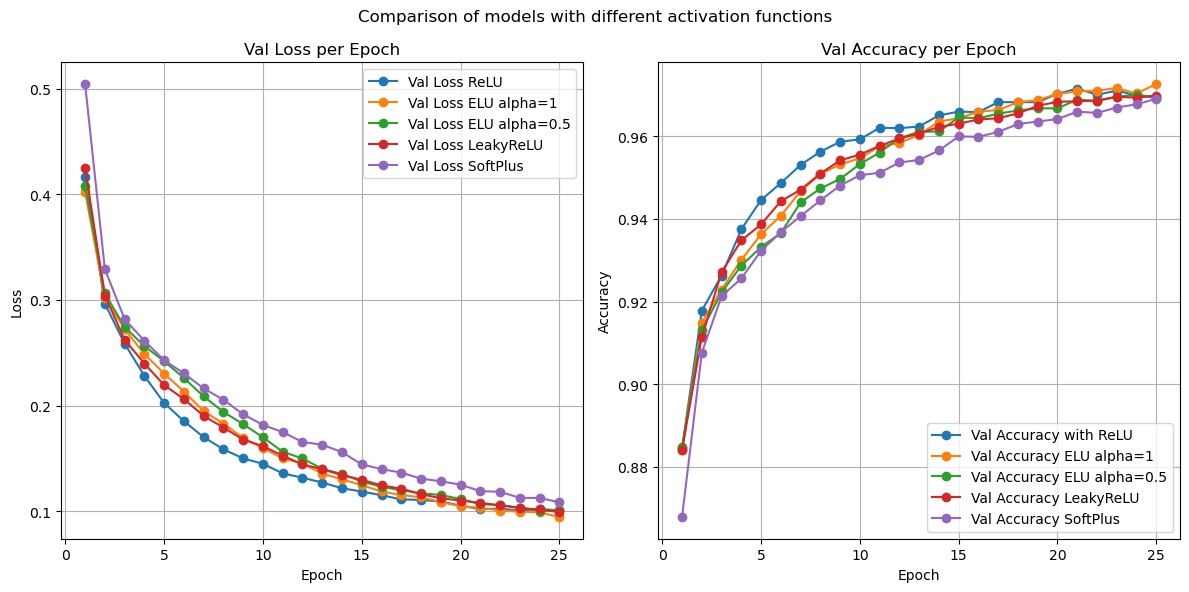

In [137]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss ReLU')
# plt.plot(range(1, len(test_losses_relu_bn) + 1), test_losses_relu_bn, marker='o', label='Test Loss with ReLU and BatchNorm')
plt.plot(range(1, len(val_losses_elu) + 1), val_losses_elu, marker='o', label='Val Loss ELU alpha=1')
plt.plot(range(1, len(val_losses_elu1) + 1), val_losses_elu1, marker='o', label='Val Loss ELU alpha=0.5')
plt.plot(range(1, len(val_losses_leaky) + 1), val_losses_leaky, marker='o', label='Val Loss LeakyReLU')
plt.plot(range(1, len(val_losses_softplus) + 1), val_losses_softplus, marker='o', label='Val Loss SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o',  label='Val Accuracy with ReLU')
# plt.plot(range(1, len(test_accuracies_relu_bn) + 1), test_accuracies_relu_bn, marker='o',  label='Test Accuracy with ReLU and BatchNorm')
plt.plot(range(1, len(val_accuracies_elu) + 1), val_accuracies_elu, marker='o',  label='Val Accuracy ELU alpha=1')
plt.plot(range(1, len(val_accuracies_elu1) + 1), val_accuracies_elu1, marker='o',  label='Val Accuracy ELU alpha=0.5')
plt.plot(range(1, len(val_accuracies_leaky) + 1), val_accuracies_leaky, marker='o',  label='Val Accuracy LeakyReLU')
plt.plot(range(1, len(val_accuracies_softplus) + 1), val_accuracies_softplus, marker='o', label='Val Accuracy SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of models with different activation functions')
plt.tight_layout()

plt.show()

**Функции активации:**
* Видно, что различные функции активации влияют на скорость сходимости, например SoftPlus и ELU дают меньшую скорость сходимости по сравнению с ReLU и LeakyReLU
* SoftPlus и ELU более сложные в вычислениях, хотя получаемая кривая обучения получается более гладкая нежели с ReLU или LeakyReLU
* Считается что ELU обладает более высокой скоростью сходимости, но в данном случае получаем противоположный результат. При изменении альфа, в данном случае, практически ничего не меняется.

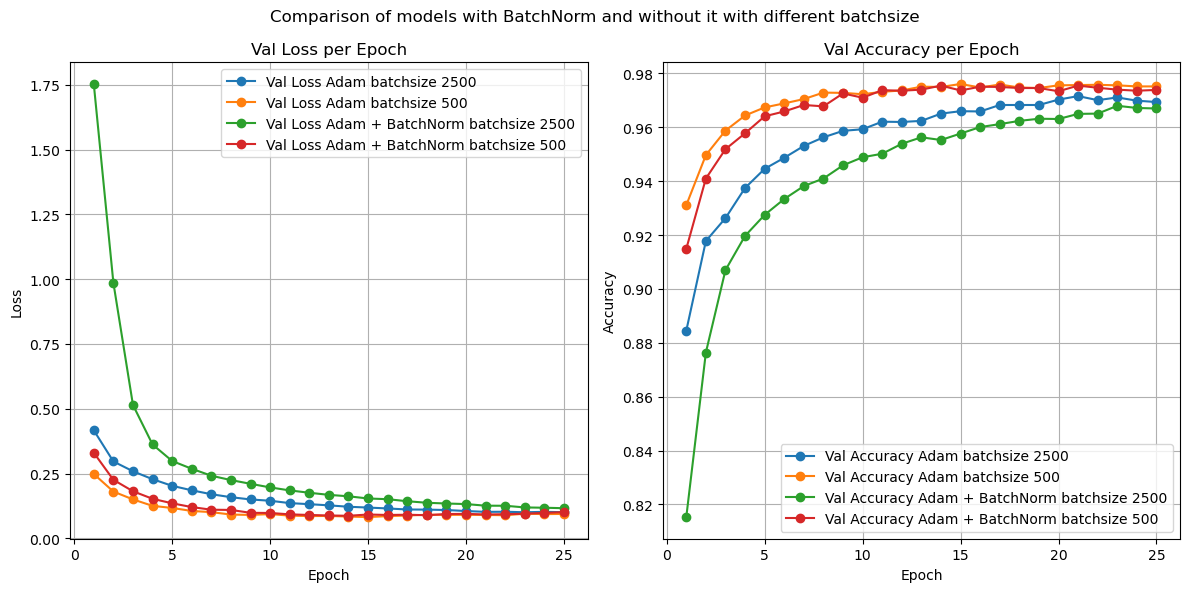

In [138]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss Adam batchsize 2500')
plt.plot(range(1, len(val_losses_relu3) + 1), val_losses_relu3, marker='o', label='Val Loss Adam batchsize 500')
plt.plot(range(1, len(val_losses_relu_bn) + 1), val_losses_relu_bn, marker='o', label='Val Loss Adam + BatchNorm batchsize 2500')
plt.plot(range(1, len(val_losses_relu_bn1) + 1), val_losses_relu_bn1, marker='o', label='Val Loss Adam + BatchNorm batchsize 500')
# plt.plot(range(1, len(val_losses_relu_sgd) + 1), val_losses_relu_sgd, marker='o', label='Test Loss SGD')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o', label='Val Accuracy Adam batchsize 2500')
plt.plot(range(1, len(val_accuracies_relu3) + 1), val_accuracies_relu3, marker='o', label='Val Accuracy Adam batchsize 500')
plt.plot(range(1, len(val_accuracies_relu_bn) + 1), val_accuracies_relu_bn, marker='o',  label='Val Accuracy Adam + BatchNorm batchsize 2500')
plt.plot(range(1, len(val_accuracies_relu_bn1) + 1), val_accuracies_relu_bn1, marker='o',  label='Val Accuracy Adam + BatchNorm batchsize 500')
# plt.plot(range(1, len(val_accuracies_relu_sgd) + 1), val_accuracies_relu_sgd, marker='o',label='Test Accuracy SGD' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of models with BatchNorm and without it with different batchsize')
plt.tight_layout()

plt.show()

**BatchNormalisation**
* Написано, что BatchNorm улучшает численную сходимость. В данном случае в результате экспериментов с шагом обучения, был момент, когда происходило переполнение градиента (взрыв) и применение BatchNorm помогло справится с этой проблемой.
* В данном случае получается небольшое различие с применением BatchNorm и без, но в итоге обе модели сходятся практически к одному значению accuracy.
* Из минусов можно отметить зависимость от размера бача и наличие дополнительных вычислений.
* Размер бача влияет на скорость сходимости, и на стабильность кривой обучения, с большим размером бача получается меньшее количество колебаний в процессе обучения

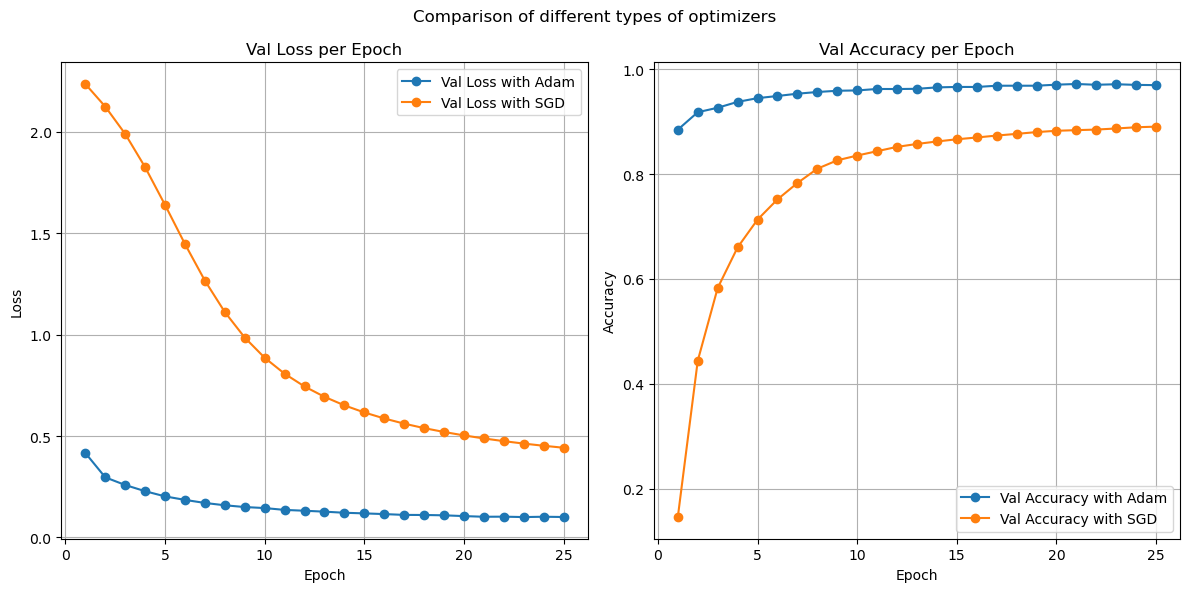

In [145]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss with Adam')
# plt.plot(range(1, len(val_losses_relu1) + 1), val_losses_relu1, marker='o', label='Test Loss w/o BatchNorm Adam')
plt.plot(range(1, len(val_losses_sgd) + 1), val_losses_sgd, marker='o', label='Val Loss with SGD')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o', label='Val Accuracy with Adam')
# plt.plot(range(1, len(val_accuracies_relu1) + 1), val_accuracies_relu1, marker='o',  label='Test Accuracy w/o BatchNorm Adam')
plt.plot(range(1, len(val_accuracies_sgd) + 1), val_accuracies_sgd, marker='o',label='Val Accuracy with SGD' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of different types of optimizers')
plt.tight_layout()

plt.show()

**Различные оптимизаторы**
* SGD медленнее сходится и сходится к более высокому значению лосса нежели Adam
* Adam выходит на плато по точности приблизительно за 15 эпох, в то время как accuracy у SGD все еще растет, но на более низких значениях и за 25 эпох не достигает показателей Adam. 

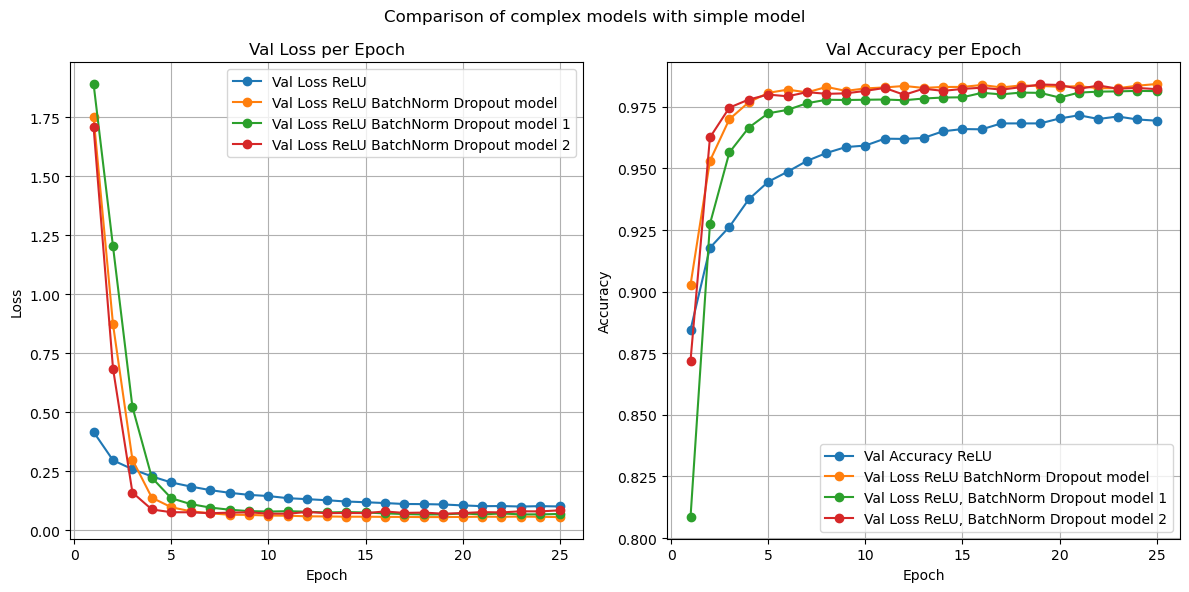

In [146]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss ReLU')
# plt.plot(range(1, len(val_losses_relu_bn) + 1), val_losses_relu_bn, marker='o', label='Test Loss with ReLU and BatchNorm')
plt.plot(range(1, len(val_losses_final) + 1), val_losses_final, marker='o', label='Val Loss ReLU BatchNorm Dropout model')
plt.plot(range(1, len(val_losses_final1) + 1), val_losses_final1, marker='o', label='Val Loss ReLU BatchNorm Dropout model 1')
plt.plot(range(1, len(val_losses_final2) + 1), val_losses_final2, marker='o', label='Val Loss ReLU BatchNorm Dropout model 2')



plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o',  label='Val Accuracy ReLU')
# plt.plot(range(1, len(val_accuracies_relu_bn) + 1), val_accuracies_relu_bn, marker='o',  label='Test Accuracy with ReLU and BatchNorm')
plt.plot(range(1, len(val_accuracies_final) + 1), val_accuracies_final, marker='o', label='Val Loss ReLU BatchNorm Dropout model')
plt.plot(range(1, len(val_accuracies_final1) + 1), val_accuracies_final1, marker='o', label='Val Loss ReLU, BatchNorm Dropout model 1')
plt.plot(range(1, len(val_accuracies_final2) + 1), val_accuracies_final2, marker='o', label='Val Loss ReLU, BatchNorm Dropout model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of complex models with simple model')
plt.tight_layout()

plt.show()

**Сравнение простой модели со сложными**

По графикам видно что более сложные модели выходят на более высокий уровень accuracy. Однако более сильное увеличение сложности модели не дает существенного увеличение accuracy. 
Хотя если смотреть численные значения, то самое высокое значение accuracy полученно с модели с самым большим количеством слоев.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

# ответы под графиками

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

# ответы под графиками

Print here your accuracy on test set. It should be around 90%.

In [150]:
print("Accuracy и Loss на тестовых данных для обученных моделей")
labels = ["ReLU", "ELU", "SoftPlus", "LeakyReLU", "ReLU BatchNorm", "ReLU SGD", "ReLU BatchNorm Dropout model", "ReLU BatchNorm Dropout model 1", "ReLU BatchNorm Dropout model 2"]
test_acc = [ acc_relu, acc_elu, acc_softplus, acc_leaky, acc_relu_bn, acc_sgd, acc_final, acc_final1, acc_final2]
test_loss = [ loss_relu, loss_elu, loss_softplus, loss_leaky, loss_relu_bn, loss_sgd, loss_final, loss_final1, loss_final2]
for acc, loss, text in zip(test_acc, test_loss, labels):

    print(f"accuracy: {acc:.4f}    {text}")

Accuracy и Loss на тестовых данных для обученных моделей
accuracy: 0.9720    ReLU
accuracy: 0.9694    ELU
accuracy: 0.9671    SoftPlus
accuracy: 0.9702    LeakyReLU
accuracy: 0.9670    ReLU BatchNorm
accuracy: 0.8868    ReLU SGD
accuracy: 0.9831    ReLU BatchNorm Dropout model
accuracy: 0.9776    ReLU BatchNorm Dropout model 1
accuracy: 0.9825    ReLU BatchNorm Dropout model 2


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_train = X_train.view(-1, 784)  
X_val = X_val.view(-1, 784)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



class MNISTLinearClassifier(nn.Module):
    def __init__(self):
        super(MNISTLinearClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MNISTLinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 20
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        _, target_labels = torch.max(target, 1)
        total += target.size(0)
        correct += (predicted == target_labels).sum().item()

    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

Epoch [1/20], Step [100/938], Loss: 0.4597
Epoch [1/20], Step [200/938], Loss: 0.3228
Epoch [1/20], Step [300/938], Loss: 0.2792
Epoch [1/20], Step [400/938], Loss: 0.3035
Epoch [1/20], Step [500/938], Loss: 0.1494
Epoch [1/20], Step [600/938], Loss: 0.1195
Epoch [1/20], Step [700/938], Loss: 0.1101
Epoch [1/20], Step [800/938], Loss: 0.0749
Epoch [1/20], Step [900/938], Loss: 0.1277
Epoch [2/20], Step [100/938], Loss: 0.1142
Epoch [2/20], Step [200/938], Loss: 0.0692
Epoch [2/20], Step [300/938], Loss: 0.0118
Epoch [2/20], Step [400/938], Loss: 0.1949
Epoch [2/20], Step [500/938], Loss: 0.1343
Epoch [2/20], Step [600/938], Loss: 0.0596
Epoch [2/20], Step [700/938], Loss: 0.1411
Epoch [2/20], Step [800/938], Loss: 0.0755
Epoch [2/20], Step [900/938], Loss: 0.0544
Epoch [3/20], Step [100/938], Loss: 0.0393
Epoch [3/20], Step [200/938], Loss: 0.1171
Epoch [3/20], Step [300/938], Loss: 0.0301
Epoch [3/20], Step [400/938], Loss: 0.0076
Epoch [3/20], Step [500/938], Loss: 0.0116
Epoch [3/20

С помощью PyTorch получаем модель сопоставимую по точности с нашей моделью. 
* PyTorch accuracy: **0.9827**
* Моя модель с 4 линейными слоями c BatchNormalization и одним Dropout дала accuracy: **0.9831**